In [1]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
import html
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

C:\Users\PC\AppData\Local\Temp\ipykernel_20380\1542523893.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


In [3]:
# Keep the desired columns
data = data[['text','Openness to Experience', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism', 'class']]

# Encode the 'class' column as a numeric type
data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})

# Remove the percentage symbols and convert the data to floating numbers
data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
data['Conscientiousness'] = data['Conscientiousness'].str.rstrip('%').astype(float)
data['Extraversion'] = data['Extraversion'].str.rstrip('%').astype(float)
data['Agreeableness'] = data['Agreeableness'].str.rstrip('%').astype(float)
data['Neuroticism'] = data['Neuroticism'].str.rstrip('%').astype(float)

# Check the data type of each column
print(data.dtypes)
data

text                       object
Openness to Experience    float64
Conscientiousness         float64
Extraversion              float64
Agreeableness             float64
Neuroticism               float64
class                       int64
dtype: object


C:\Users\PC\AppData\Local\Temp\ipykernel_20380\3006196770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})
C:\Users\PC\AppData\Local\Temp\ipykernel_20380\3006196770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
C:\Users\PC\AppData\Local\Temp\ipykernel_20380\3006196770.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,text,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism,class
0,Ex Wife Threatening SuicideRecently I left my ...,51.0,68.0,27.0,35.0,67.0,1
1,Am I weird I don't get affected by compliments...,98.0,0.0,1.0,17.0,100.0,0
2,Finally 2020 is almost over... So I can never ...,89.0,7.0,1.0,11.0,56.0,0
3,"Everyone wants to be ""edgy"" and it's making me...",97.0,12.0,22.0,26.0,93.0,0
4,I took the rest of my sleeping pills and my pa...,98.0,69.0,0.0,63.0,90.0,1
...,...,...,...,...,...,...,...
995,I'm a 17 year old senior and I sometimes feel ...,75.0,37.0,26.0,36.0,85.0,1
996,I just want to go to sleep and not wake upI ha...,76.0,21.0,0.0,17.0,97.0,1
997,Help. I'm so lost.I feel so helpless despite t...,88.0,25.0,18.0,15.0,99.0,1
998,Anybody else get really scared when you get cl...,98.0,41.0,49.0,54.0,98.0,1


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


Word2Vec + CNN-BiLSTM

In [5]:
y = data['class']
X_train1, X_test1, y_train1, y_test1 = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)


In [6]:
from gensim.models import KeyedVectors
from keras.utils import to_categorical

# Train set and test set split
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(data[['preprocessed_text', 'Extraversion', 'Agreeableness', 'Neuroticism']], y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['preprocessed_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['preprocessed_text'])

num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Extract Big 5 personality scores
train_scores = X_train[['Extraversion', 'Agreeableness', 'Neuroticism']].values
test_scores = X_test[['Extraversion', 'Agreeableness', 'Neuroticism']].values

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Create the word embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [8]:
!pip install optuna
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import optuna

# Define the function that creates the model
def create_model(lstm_units, dense_units, dropout_rate):
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
    x = Conv1D(100, 5, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))(x)

    personality_input = Input(shape=(3,), name='personality_input')
    p = Dense(32, activation='relu')(personality_input)

    combined = Concatenate()([x, p])

    x = Dense(dense_units, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[text_input, personality_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the target function
def objective(trial):
    # Hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 100, 150)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    model = create_model(lstm_units, dense_units, dropout_rate)

    # Train the model
    model.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
              batch_size=32,
              epochs=10,
              verbose=0)

    # Evaluate the model
    scores = model.evaluate([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_test, verbose=0)
    return scores[1]

# Creat Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-02 18:36:02,328] A new study created in memory with name: no-name-f5fa7ee5-871a-4fb2-bb6f-6a29a0f02643


[I 2025-03-02 18:36:52,789] Trial 0 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 130, 'dense_units': 54, 'dropout_rate': 0.25786305447347024}. Best is trial 0 with value: 0.9049999713897705.


[I 2025-03-02 18:37:38,575] Trial 1 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 134, 'dense_units': 112, 'dropout_rate': 0.350246351644918}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:38:24,845] Trial 2 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 110, 'dense_units': 38, 'dropout_rate': 0.1718903617306581}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:39:10,385] Trial 3 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 120, 'dense_units': 50, 'dropout_rate': 0.24980697819068862}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:40:01,618] Trial 4 finished with value: 0.800000011920929 and parameters: {'lstm_units': 124, 'dense_units': 33, 'dropout_rate': 0.1778614792209254}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:40:49,768] Trial 5 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 135, 'dense_units': 72, 'dropout_rate': 0.3392649139940972}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:41:39,041] Trial 6 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 108, 'dense_units': 60, 'dropout_rate': 0.5012806161367453}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:42:28,549] Trial 7 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 128, 'dense_units': 85, 'dropout_rate': 0.4526768411910652}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:43:19,311] Trial 8 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 130, 'dense_units': 53, 'dropout_rate': 0.4056086336377476}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:44:06,341] Trial 9 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 144, 'dense_units': 57, 'dropout_rate': 0.5944887601066607}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:44:58,866] Trial 10 finished with value: 0.8650000095367432 and parameters: {'lstm_units': 148, 'dense_units': 117, 'dropout_rate': 0.3224365481896844}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:45:47,344] Trial 11 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 137, 'dense_units': 124, 'dropout_rate': 0.42975493783124596}. Best is trial 1 with value: 0.9300000071525574.


[I 2025-03-02 18:46:37,360] Trial 12 finished with value: 0.9350000023841858 and parameters: {'lstm_units': 118, 'dense_units': 93, 'dropout_rate': 0.42687640382320513}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:47:27,110] Trial 13 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 117, 'dense_units': 103, 'dropout_rate': 0.5496560545884908}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:48:16,875] Trial 14 finished with value: 0.925000011920929 and parameters: {'lstm_units': 115, 'dense_units': 100, 'dropout_rate': 0.37856980055962697}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:49:06,076] Trial 15 finished with value: 0.8399999737739563 and parameters: {'lstm_units': 102, 'dense_units': 97, 'dropout_rate': 0.10072130112305944}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:49:52,879] Trial 16 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 139, 'dense_units': 113, 'dropout_rate': 0.489564833170705}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:50:42,055] Trial 17 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 122, 'dense_units': 87, 'dropout_rate': 0.2990125243971975}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:51:37,279] Trial 18 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 112, 'dense_units': 74, 'dropout_rate': 0.36387586445538117}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:52:30,782] Trial 19 finished with value: 0.9200000166893005 and parameters: {'lstm_units': 104, 'dense_units': 106, 'dropout_rate': 0.4749145357157044}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:53:24,070] Trial 20 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 132, 'dense_units': 128, 'dropout_rate': 0.2698863793110392}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:54:13,003] Trial 21 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 126, 'dense_units': 92, 'dropout_rate': 0.40820698777646564}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:55:06,368] Trial 22 finished with value: 0.8650000095367432 and parameters: {'lstm_units': 143, 'dense_units': 68, 'dropout_rate': 0.4211085266405602}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:55:55,907] Trial 23 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 133, 'dense_units': 111, 'dropout_rate': 0.38981616646833434}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:56:48,903] Trial 24 finished with value: 0.925000011920929 and parameters: {'lstm_units': 118, 'dense_units': 43, 'dropout_rate': 0.5317404036930317}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:57:42,743] Trial 25 finished with value: 0.8600000143051147 and parameters: {'lstm_units': 128, 'dense_units': 79, 'dropout_rate': 0.35241197275411895}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:58:42,777] Trial 26 finished with value: 0.8849999904632568 and parameters: {'lstm_units': 138, 'dense_units': 91, 'dropout_rate': 0.45994062135426317}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 18:59:28,010] Trial 27 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 123, 'dense_units': 118, 'dropout_rate': 0.4339377863725884}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:00:13,838] Trial 28 finished with value: 0.8999999761581421 and parameters: {'lstm_units': 142, 'dense_units': 80, 'dropout_rate': 0.28917507529844144}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:00:59,666] Trial 29 finished with value: 0.8550000190734863 and parameters: {'lstm_units': 131, 'dense_units': 64, 'dropout_rate': 0.2382142098397803}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:01:44,148] Trial 30 finished with value: 0.9350000023841858 and parameters: {'lstm_units': 149, 'dense_units': 48, 'dropout_rate': 0.31724707384517536}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:02:28,565] Trial 31 finished with value: 0.8799999952316284 and parameters: {'lstm_units': 149, 'dense_units': 49, 'dropout_rate': 0.33018569799969266}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:03:13,282] Trial 32 finished with value: 0.8550000190734863 and parameters: {'lstm_units': 114, 'dense_units': 39, 'dropout_rate': 0.3883701177594123}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:03:57,749] Trial 33 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 146, 'dense_units': 42, 'dropout_rate': 0.22779402397457535}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:04:43,999] Trial 34 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 120, 'dense_units': 50, 'dropout_rate': 0.30727057487330184}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:05:31,437] Trial 35 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 127, 'dense_units': 33, 'dropout_rate': 0.20740989864264187}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:06:16,533] Trial 36 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 135, 'dense_units': 65, 'dropout_rate': 0.3527559124371018}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:07:02,208] Trial 37 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 140, 'dense_units': 49, 'dropout_rate': 0.27311770049432016}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:07:46,119] Trial 38 finished with value: 0.8899999856948853 and parameters: {'lstm_units': 109, 'dense_units': 59, 'dropout_rate': 0.40273819667312716}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:08:32,223] Trial 39 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 129, 'dense_units': 54, 'dropout_rate': 0.5244541612815286}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:09:17,423] Trial 40 finished with value: 0.925000011920929 and parameters: {'lstm_units': 150, 'dense_units': 94, 'dropout_rate': 0.43952045584143645}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:10:02,871] Trial 41 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 118, 'dense_units': 103, 'dropout_rate': 0.5884056459615223}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:10:47,984] Trial 42 finished with value: 0.9150000214576721 and parameters: {'lstm_units': 116, 'dense_units': 104, 'dropout_rate': 0.5616132514998862}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:11:32,489] Trial 43 finished with value: 0.925000011920929 and parameters: {'lstm_units': 125, 'dense_units': 110, 'dropout_rate': 0.3292554193905227}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:12:18,806] Trial 44 finished with value: 0.8399999737739563 and parameters: {'lstm_units': 120, 'dense_units': 99, 'dropout_rate': 0.5127309051456045}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:13:04,641] Trial 45 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 106, 'dense_units': 87, 'dropout_rate': 0.5482610934084827}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:13:49,923] Trial 46 finished with value: 0.9300000071525574 and parameters: {'lstm_units': 112, 'dense_units': 121, 'dropout_rate': 0.37894380617914375}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:14:35,744] Trial 47 finished with value: 0.9200000166893005 and parameters: {'lstm_units': 135, 'dense_units': 108, 'dropout_rate': 0.484494389311178}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:15:21,393] Trial 48 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 122, 'dense_units': 97, 'dropout_rate': 0.45815490211860255}. Best is trial 12 with value: 0.9350000023841858.


[I 2025-03-02 19:16:06,592] Trial 49 finished with value: 0.8100000023841858 and parameters: {'lstm_units': 147, 'dense_units': 75, 'dropout_rate': 0.1636053320959739}. Best is trial 12 with value: 0.9350000023841858.


Best trial:
  Value:  0.9350000023841858
  Params: 
    lstm_units: 118
    dense_units: 93
    dropout_rate: 0.42687640382320513


In [11]:
# Retrain the model using the best parameters
best_params = study.best_params
model = create_model(best_params['lstm_units'], best_params['dense_units'], best_params['dropout_rate'])
model.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
          batch_size=32,
          epochs=20)

# Evaluate the model on the test set
y_prob = model.predict([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test_labels, y_pred, digits=4))

Epoch 1/20
25/25 [==============================] - 7s 170ms/step - loss: 2.4267 - accuracy: 0.6125
Epoch 2/20
25/25 [==============================] - 5s 186ms/step - loss: 1.6249 - accuracy: 0.6350
Epoch 3/20
25/25 [==============================] - 5s 214ms/step - loss: 0.8615 - accuracy: 0.6888
Epoch 4/20
25/25 [==============================] - 7s 269ms/step - loss: 0.4860 - accuracy: 0.8000
Epoch 5/20
25/25 [==============================] - 5s 212ms/step - loss: 0.3771 - accuracy: 0.8687
Epoch 6/20
25/25 [==============================] - 5s 184ms/step - loss: 0.3695 - accuracy: 0.8512
Epoch 7/20
25/25 [==============================] - 4s 174ms/step - loss: 0.2745 - accuracy: 0.9087
Epoch 8/20
25/25 [==============================] - 5s 182ms/step - loss: 0.2486 - accuracy: 0.9175
Epoch 9/20
25/25 [==============================] - 4s 167ms/step - loss: 0.2157 - accuracy: 0.9237
Epoch 10/20
25/25 [==============================] - 4s 168ms/step - loss: 0.2285 - accuracy: 0.9225

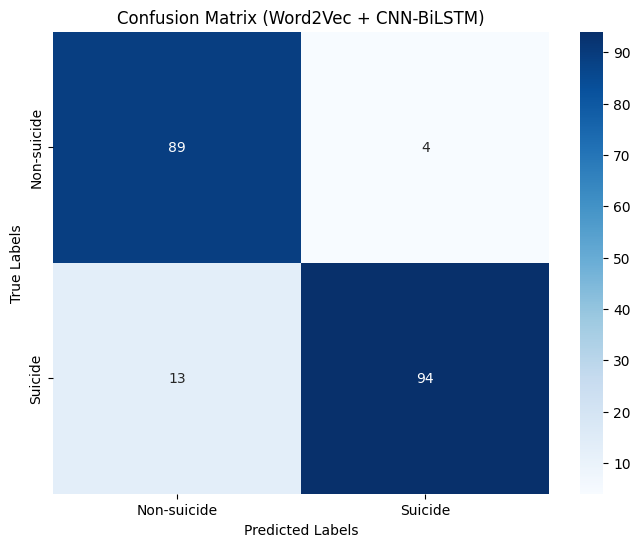

In [12]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM)')
plt.show()

Experiment: CNN + biLSTM + Attention

In [27]:
from keras.layers import Attention, Dot, Activation, RepeatVector, Permute, Lambda, BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

def create_model_with_attention(lstm_units, dense_units, dropout_rate, l2_lambda, learning_rate):
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
    x = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = MaxPooling1D()(x)

    # BiLSTM Layer
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))(x)

    # Apply Built-in Attention
    attention = Attention()([lstm_out, lstm_out])  # Self-attention

    # # Flatten Attention Output
    flatten = Flatten()(attention)

    # Batch Normalization
    bn = BatchNormalization()(flatten)

    personality_input = Input(shape=(3,), name='personality_input')
    p = Dense(32, activation='relu')(personality_input)

    combined = Concatenate()([bn, p])

    dense1 = Dense(dense_units, activation="relu", kernel_regularizer=l2(l2_lambda))(combined)
    drop1 = Dropout(dropout_rate)(dense1)
    dense2 = Dense(dense_units // 2, activation="relu", kernel_regularizer=l2(l2_lambda))(drop1)  # Half-sized Dense Layer
    drop2 = Dropout(dropout_rate)(dense2)
    output = Dense(2, activation='softmax', kernel_regularizer=l2(l2_lambda))(drop2)

    # personality_input = Input(shape=(3,), name='personality_input')
    # p = Dense(32, activation='relu')(personality_input)

    # combined = Concatenate()([flatten, p])

    # x = Dense(dense_units, activation='relu')(combined)
    # x = Dropout(dropout_rate)(x)
    # output = Dense(2, activation='softmax')(x)
    model = Model(inputs=[text_input, personality_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
    

In [29]:
#use params from reference
lstm_units = 64
dropout_rate = 0.5
l2_lambda = 0.01
learning_rate = 0.0001

model = create_model_with_attention(lstm_units, lstm_units, dropout_rate, l2_lambda, learning_rate)
early_stopping = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

model.fit([X_train_padded, train_scores], y_train, batch_size=512, epochs=40, callbacks=[early_stopping])

y_prob = model.predict([X_test_padded, test_scores])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('Word2Vec + CNN-BiLSTM + Attention Results:')
print(classification_report(y_test_labels, y_pred, digits=4))

Epoch 1/40
2/2 [==============================] - 4s 484ms/step - loss: 5.4377 - accuracy: 0.4600
Epoch 2/40
2/2 [==============================] - 1s 415ms/step - loss: 4.8699 - accuracy: 0.5713
Epoch 3/40
2/2 [==============================] - 1s 417ms/step - loss: 4.9354 - accuracy: 0.5938
Epoch 4/40
2/2 [==============================] - 1s 407ms/step - loss: 4.7122 - accuracy: 0.6288
Epoch 5/40
2/2 [==============================] - 1s 478ms/step - loss: 4.7197 - accuracy: 0.6050
Epoch 6/40
2/2 [==============================] - 1s 404ms/step - loss: 4.5578 - accuracy: 0.6237
Epoch 7/40
2/2 [==============================] - 1s 483ms/step - loss: 4.5880 - accuracy: 0.6087
Epoch 8/40
2/2 [==============================] - 1s 400ms/step - loss: 4.4969 - accuracy: 0.6187
Epoch 9/40
2/2 [==============================] - 1s 416ms/step - loss: 4.3964 - accuracy: 0.6087
Epoch 10/40
2/2 [==============================] - 1s 416ms/step - loss: 4.3118 - accuracy: 0.6513
Epoch 11/40
2/2 [==

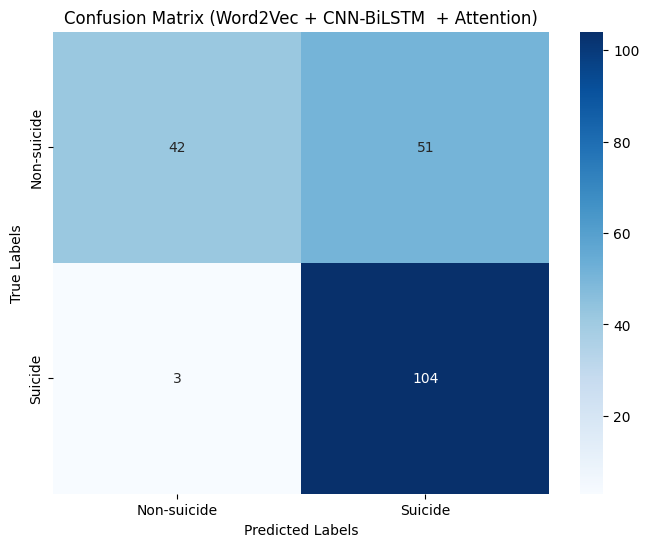

In [30]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM  + Attention)')
plt.show()

BERT

In [5]:
# BERT preprocessor does not require stopword, punctuation removal or tokenization, lemmatization
def preprocess_bert(text):
    tokenizer = TweetTokenizer(reduce_len=True)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Lowercasing
    text = text.lower()

    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in ['"','#ff', 'ff', 'rt']]
    text = ' '.join(tokens)

    return text

data['preprocessed_text_bert'] = data.text.apply(preprocess_bert)
data[['text','preprocessed_text_bert']].head(10)

,text,preprocessed_text_bert
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,am i weird i don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,finally 2020 is almost over ... so i can never...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone wants to be edgy and it's making me s...
4,I took the rest of my sleeping pills and my pa...,i took the rest of my sleeping pills and my pa...
5,Can you imagine getting old? Me neither.Wrinkl...,can you imagine getting old ? me neither.wrink...
6,Do you think getting hit by a train would be p...,do you think getting hit by a train would be p...
7,"death, continuedI posted here before and saw s...","death , continuedi posted here before and saw ..."
8,Fuck the verizon smart family app I can’t even...,fuck the verizon smart family app i can ’ t ev...
9,I’m scared. Everything just seems to be gett...,i ’ m scared . everything just seems to be get...


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.metrics import classification_report
import pandas as pd

# Process the labels, making sure all labels are between 0 and 1
labels = data['class']

# Processing text
texts = data['preprocessed_text_bert']
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the text data as BERT input
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Handle additional features
extra_features = data[['Extraversion', 'Agreeableness', 'Neuroticism']].values
extra_features = torch.tensor(extra_features, dtype=torch.float32)

# Create the label tensor and make sure it's a Long
labels = torch.tensor(labels, dtype=torch.long)

# Creat TensorDataset
dataset = TensorDataset(input_ids, attention_masks, extra_features, labels)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=8)

# Define the model
class BertWithExtraFeatures(nn.Module):
    def __init__(self, bert_model, extra_feature_size, num_labels):
        super(BertWithExtraFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.extra_feature_size = extra_feature_size
        self.num_labels = num_labels

        self.classifier = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size + extra_feature_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, extra_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        combined_output = torch.cat((pooled_output, extra_features), dim=1)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)
        return logits

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2)

# Use CUDA (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Train and validate the model
for epoch in range(10):
    # Train the loop
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        model.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_extra_features)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} finished.")

    # Validate the loop
    model.eval()
    val_labels = []
    val_preds = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)

        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT with personality Results:')
print(classification_report(val_labels, val_preds, digits=4))

Epoch 1 finished.
Epoch 2 finished.
Epoch 3 finished.
Epoch 4 finished.
Epoch 5 finished.
Epoch 6 finished.
Epoch 7 finished.
Epoch 8 finished.
Epoch 9 finished.
Epoch 10 finished.
BERT with personality Results:
              precision    recall  f1-score   support

           0     0.9479    0.9100    0.9286       100
           1     0.9135    0.9500    0.9314       100

    accuracy                         0.9300       200
   macro avg     0.9307    0.9300    0.9300       200
weighted avg     0.9307    0.9300    0.9300       200



#### Hyperparameter optimization

In [10]:
!pip install optuna

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.metrics import classification_report
import pandas as pd
import optuna

# Processing text
texts = data['preprocessed_text_bert']
labels = data['class']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the text data as BERT input
encoded_data = tokenizer.batch_encode_plus(
    texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Handle additional features
extra_features = data[['Extraversion', 'Agreeableness', 'Neuroticism']].values
extra_features = torch.tensor(extra_features, dtype=torch.float32)

# Create the label tensor
labels = torch.tensor(labels, dtype=torch.long)

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, extra_features, labels)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=8)

# Define the model
class BertWithExtraFeatures(nn.Module):
    def __init__(self, bert_model, extra_feature_size, num_labels, dropout_rate):
        super(BertWithExtraFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout_rate)
        self.extra_feature_size = extra_feature_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size + extra_feature_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, extra_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        combined_output = torch.cat((pooled_output, extra_features), dim=1)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)
        return logits

# Hyperparameter optimization using Optuna
def objective(trial):
    # Hyperparameter Search space
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)  # Expand the scope
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)  # Expand the scope

    # Initialize the BERT model
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2, dropout_rate=dropout_rate)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    total_steps = len(train_dataloader) * 3  # Suppose 3 epochs are trained for hyperparameter search
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    # Train the model
    for epoch in range(3):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_extra_features, b_labels = batch

            optimizer.zero_grad()
            logits = model(b_input_ids, b_input_mask, b_extra_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

    # Evaluate the model
    model.eval()
    val_labels = []
    val_preds = []
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

    f1 = f1_score(val_labels, val_preds, average='weighted')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase the number of attempts

best_params = study.best_params
print(f"Best Parameters: {best_params}")

[I 2025-03-02 21:25:22,135] A new study created in memory with name: no-name-c2c987d0-ed36-4625-97fc-ee9e86a0251a
C:\Users\PC\AppData\Local\Temp\ipykernel_24856\3861845633.py:76: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)  # Expand the scope
C:\Users\PC\AppData\Local\Temp\ipykernel_24856\3861845633.py:77: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
C:\Users\PC\AppData\Local\Temp\ipykernel_24856\3861845633.py:78: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Best Parameters: {'lr': 8.980424508981434e-05, 'dropout_rate': 0.23781976494194595, 'weight_decay': 2.4508416102798875e-06}


In [12]:
# Retrin the model using the best hyperparameters
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2, dropout_rate=best_params['dropout_rate'])
model.to(device)

optimizer = AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Train and evaluate the model
for epoch in range(10):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        optimizer.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_extra_features)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss / len(train_dataloader)}")

    model.eval()
    val_labels = []
    val_preds = []
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT with personality & best params Results:')
print(classification_report(val_labels, val_preds, digits=4))

c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 finished. Loss: 0.4997242139279842
Epoch 2 finished. Loss: 0.22435671374201774
Epoch 3 finished. Loss: 0.15459230545908212
Epoch 4 finished. Loss: 0.13949857603758573
Epoch 5 finished. Loss: 0.1389790053293109
Epoch 6 finished. Loss: 0.13476582668721676
Epoch 7 finished. Loss: 0.14528854127973317
Epoch 8 finished. Loss: 0.1262598066404462
Epoch 9 finished. Loss: 0.13378788338974118
Epoch 10 finished. Loss: 0.1342900722101331
BERT with personality & best params Results:
              precision    recall  f1-score   support

           0     0.9307    0.9126    0.9216       103
           1     0.9091    0.9278    0.9184        97

    accuracy                         0.9200       200
   macro avg     0.9199    0.9202    0.9200       200
weighted avg     0.9202    0.9200    0.9200       200



Use early stopping mechanism

In [13]:
# Retrin the model using the best hyperparameters
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2, dropout_rate=best_params['dropout_rate'])
model.to(device)

optimizer = AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Early stopping
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Train and evaluate the model
for epoch in range(10):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        optimizer.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_extra_features)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss / len(train_dataloader)}")

    # Evaluate the model
    model.eval()
    val_labels = []
    val_preds = []
    val_loss = 0
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)
            val_loss += loss.item()
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

    avg_val_loss = val_loss / len(validation_dataloader)
    print(f"Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

print('BERT with personality & best params Results:')
print(classification_report(val_labels, val_preds, digits=4))

c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 finished. Loss: 0.4558121535181999
Validation Loss: 0.45960274115204813
Epoch 2 finished. Loss: 0.20572783490642904
Validation Loss: 0.21993956953287125
Epoch 3 finished. Loss: 0.13302396163344382
Validation Loss: 0.21293781377375126
Epoch 4 finished. Loss: 0.11300863947719336
Validation Loss: 0.2129057002067566
Epoch 5 finished. Loss: 0.11336908973753453
Validation Loss: 0.21293849661946296
Epoch 6 finished. Loss: 0.11636973722837865
Validation Loss: 0.21293948113918304
Epoch 7 finished. Loss: 0.10238575607538224
Validation Loss: 0.21293947517871856
Epoch 8 finished. Loss: 0.11967840744182467
Validation Loss: 0.2129394966363907
Epoch 9 finished. Loss: 0.11937483940273523
Validation Loss: 0.2129395052790642
Epoch 10 finished. Loss: 0.1243831911124289
Validation Loss: 0.2129395042359829
BERT with personality & best params Results:
              precision    recall  f1-score   support

           0     0.9320    0.9320    0.9320       103
           1     0.9278    0.9278    0.92

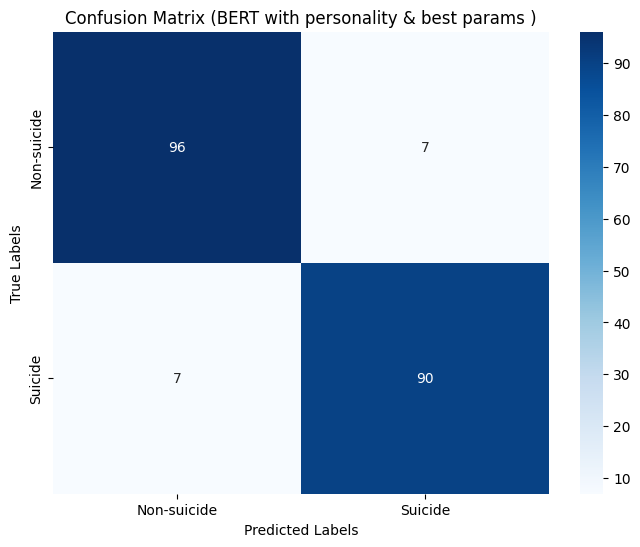

In [14]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT with personality & best params )')
plt.show()